## Customer Personality Analysis
This project analyze the marketing_campaign dataset.

This part tries to improve the last model created in part1

### let's look closer over part1 error analysis 

we get few insights:

1. the model tends to overestimate
2. some features are responsible for really high error rate, but are also important for prediction while some cause high error but lower importance in prediction.
3. there is non-linear relation between some features to the target feature.
4. there are few outliers that effect negatively on the model

some relevant metrics in the current model:

R2 Score: 0.852

Mean Absolute Perc Error (Σ(|y - pred|/y)/n): 0.338

Mean Absolute Error (Σ|y - pred|/n): 131

Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)): 229

we will try to improve it.

# simple preprocessing:

R2 Score: 0.852
Mean Absolute Perc Error (Σ(|y - pred|/y)/n): 0.338
Mean Absolute Error (Σ|y - pred|/n): 131
Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)): 229


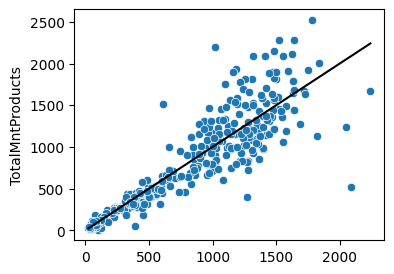

In [327]:
#data processing
import pandas as pd
import numpy as np

#data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

dtf = pd.read_csv("./data/marketing_campaign.csv", index_col=0, delimiter='\t')
cols = ['Year_Birth','Education','Marital_Status','Income',	'Kidhome','Teenhome','Dt_Customer',	'Recency', 'TotalMntProducts','NumDealsPurchases'	,'NumWebPurchases',	'NumCatalogPurchases','NumStorePurchases', 'NumWebVisitsMonth','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','AcceptedCmp1', 'AcceptedCmp2', 'Complain']
total_products = ['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']
# summing the total products:
dtf['TotalMntProducts'] = dtf[total_products].sum(axis=1)
# remove total products:
dtf = dtf.drop(total_products, axis=1)
dtf = dtf[cols]


transform_categorial_cols = ['Education', 'Marital_Status' ]
# transform string categorial columns to numerical:
dtf[transform_categorial_cols] = dtf[transform_categorial_cols].apply(lambda x: pd.factorize(x)[0])

# drop all non-numeric columns that left(only date column)
numeric_cols = dtf.select_dtypes(include=['int64', 'float64']).columns
dtf = dtf[numeric_cols]


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_percentage_error,mean_absolute_error
import matplotlib.pyplot as plt

X = dtf.drop(['TotalMntProducts'], axis=1)
y = dtf['TotalMntProducts']

transform_categorial_cols = ['Education', 'Marital_Status' ]

# transform string categorial columns to numerical:
X[transform_categorial_cols] = X[transform_categorial_cols].apply(lambda x: pd.factorize(x)[0])

# drop all non-numeric columns that left(only date column)
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
X = X[numeric_cols]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluations of model
print("R2 Score:", "{:,.3f}".format(r2_score(y_test, y_pred_test)))
print("Mean Absolute Perc Error (Σ(|y - pred|/y)/n):","{:,.3f}".format(mean_absolute_percentage_error(y_test,y_pred_test)))
print("Mean Absolute Error (Σ|y - pred|/n):", "{:,.0f}".format(mean_absolute_error(y_test, y_pred_test)))
print("Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)):", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred_test))))

fig, ax = plt.subplots(figsize=(4,3))
sns.scatterplot(x=y_pred_test ,y=y_test,ax=ax)
sns.lineplot(x=y_pred_test, y=y_pred_test,ax=ax,color='black')
plt.show()


Now from the error analysis from part1 we will try the following things:
1. remove outliers from the features: Income, purchase count
2. understand high error features better to improve their usage
3. use feature engineering for some features

In [328]:
# handle outliers in Income column and remove them using IQR method
df_clean = dtf.copy()
columns = ['Income', 'NumCatalogPurchases']
for col in columns:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

print('Number of samples filtered by IQR: {}'.format(len(dtf) - len(df_clean)))
print('Number of samples in dataset after IQR: {}'.format(len(df_clean)))


Number of samples filtered by IQR: 52
Number of samples in dataset after IQR: 2188


R2 Score: 0.896
Mean Absolute Perc Error (Σ(|y - pred|/y)/n): 0.328
Mean Absolute Error (Σ|y - pred|/n): 113
Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)): 193


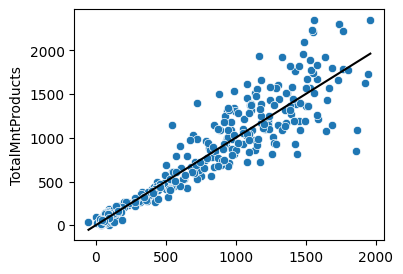

In [329]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_percentage_error,mean_absolute_error
import matplotlib.pyplot as plt

X = df_clean.drop(['TotalMntProducts'], axis=1)
y = df_clean['TotalMntProducts']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluations of model
print("R2 Score:", "{:,.3f}".format(r2_score(y_test, y_pred_test)))
print("Mean Absolute Perc Error (Σ(|y - pred|/y)/n):","{:,.3f}".format(mean_absolute_percentage_error(y_test,y_pred_test)))
print("Mean Absolute Error (Σ|y - pred|/n):", "{:,.0f}".format(mean_absolute_error(y_test, y_pred_test)))
print("Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)):", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred_test))))

fig, ax = plt.subplots(figsize=(4,3))
sns.scatterplot(x=y_pred_test ,y=y_test,ax=ax)
sns.lineplot(x=y_pred_test, y=y_pred_test,ax=ax,color='black')
plt.show()


already a nice improvment!

Now we will check again the error rate for all the features.

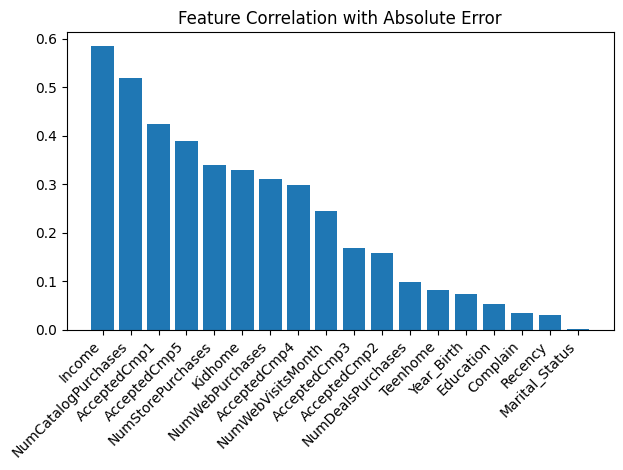

In [49]:
feature_names = X.columns
errors = y_test - y_pred_test
abs_errors = np.abs(errors)
percent_errors = (errors / y_test) * 100
feature_error_corr = pd.DataFrame()
for feature in feature_names:
    feature_error_corr.loc[feature, 'Error_Correlation'] = np.corrcoef(X_test[feature], abs_errors)[0,1]

feature_error_corr['Abs_Correlation'] = abs(feature_error_corr['Error_Correlation'])
feature_error_corr = feature_error_corr.sort_values('Abs_Correlation', ascending=False)

plt.bar(range(len(feature_error_corr)), feature_error_corr['Abs_Correlation'])
plt.xticks(range(len(feature_error_corr)), feature_error_corr.index, rotation=45, ha='right')
plt.title('Feature Correlation with Absolute Error')
plt.tight_layout()
plt.show()

Now Income became problematic and NumCatalogPurchases is problematic as before.

We will focus on NumCatalogPurchases first, we will try and manipulate the feature to fit better to the target feature.

I choose this feature first because it has 2 highest error rate and the bigget contributer to the xgboost predicting.

I converted this feature to a ratio, because these raw numbers don't show the full picture,
it is possible that someone making 10 catalog purchases only made a total of 10 purchases (100% from catalog) vs someone who made 10 out of 100 total purchases ( only 10% from catalog)


In [333]:
df_new = df_clean.copy()

total_purchases = df_new['NumCatalogPurchases'] + df_new['NumStorePurchases'] + df_new['NumWebPurchases']
df_new['Catalog_Ratio'] = df_new['NumCatalogPurchases'] / total_purchases

df_new.drop(['NumCatalogPurchases'], axis=1, inplace=True)

# Test these transformations:
X = df_new.drop(['TotalMntProducts'], axis=1)
y = df_new['TotalMntProducts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Evaluations of model
print("R2 Score:", "{:,.3f}".format(r2_score(y_test, y_pred_test)))
print("Mean Absolute Perc Error (Σ(|y - pred|/y)/n):","{:,.3f}".format(mean_absolute_percentage_error(y_test,y_pred_test)))
print("Mean Absolute Error (Σ|y - pred|/n):", "{:,.0f}".format(mean_absolute_error(y_test, y_pred_test)))
print("Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)):", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred_test))))



R2 Score: 0.902
Mean Absolute Perc Error (Σ(|y - pred|/y)/n): 0.308
Mean Absolute Error (Σ|y - pred|/n): 109
Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)): 187


With this ratio change we get another improvment in all metrics!


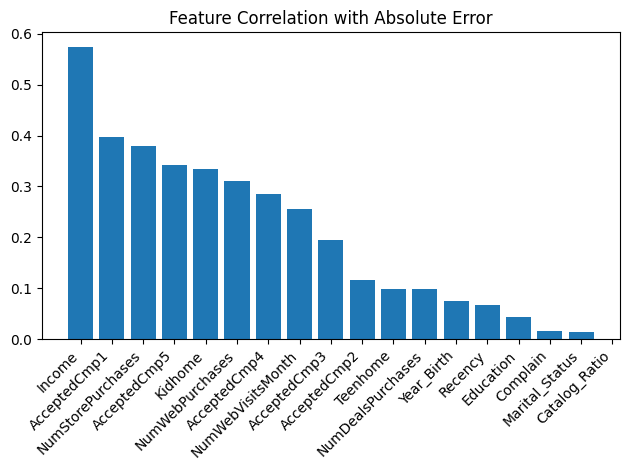

In [147]:
feature_names = X.columns
errors = y_test - y_pred_test
abs_errors = np.abs(errors)
percent_errors = (errors / y_test) * 100
feature_error_corr = pd.DataFrame()
for feature in feature_names:
    feature_error_corr.loc[feature, 'Error_Correlation'] = np.corrcoef(X_test[feature], abs_errors)[0,1]

feature_error_corr['Abs_Correlation'] = abs(feature_error_corr['Error_Correlation'])
feature_error_corr = feature_error_corr.sort_values('Abs_Correlation', ascending=False)

plt.bar(range(len(feature_error_corr)), feature_error_corr['Abs_Correlation'])
plt.xticks(range(len(feature_error_corr)), feature_error_corr.index, rotation=45, ha='right')
plt.title('Feature Correlation with Absolute Error')
plt.tight_layout()
plt.show()

Now income has the highest error rate, we will try to improve it:

At first we try to change the scale of Income to log/sqrt/coxbox because we thought maybe there is non-linear relationship with Income and the target feature. but it didn't change anything, which implies that this feature is not independant.  when combined with ratio we got improvment.

In [354]:
df_income = df_new.copy()

# 1. Income transformation to log scale(didn't work alone)
df_income['Income_Log'] = np.log1p(df_income['Income'])
df_income.drop(['Income'], axis=1, inplace=True)

# add interaction between income and catalog ratio
df_income['Income_Catalog_Interaction'] = df_income['Income_Log'] * df_income['Catalog_Ratio']


# Test these transformations:
X = df_income.drop(['TotalMntProducts'], axis=1)
y = df_income['TotalMntProducts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Evaluations of model
print("R2 Score:", "{:,.3f}".format(r2_score(y_test, y_pred_test)))
print("Mean Absolute Perc Error (Σ(|y - pred|/y)/n):","{:,.3f}".format(mean_absolute_percentage_error(y_test,y_pred_test)))
print("Mean Absolute Error (Σ|y - pred|/n):", "{:,.0f}".format(mean_absolute_error(y_test, y_pred_test)))
print("Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)):", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred_test))))



R2 Score: 0.905
Mean Absolute Perc Error (Σ(|y - pred|/y)/n): 0.323
Mean Absolute Error (Σ|y - pred|/n): 107
Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)): 184


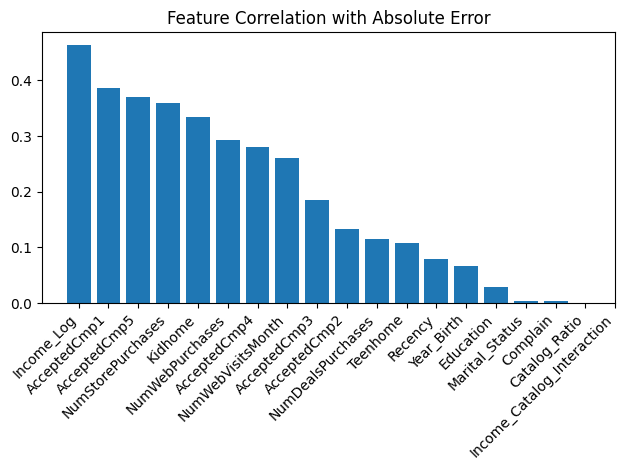

In [356]:
feature_names = X.columns
errors = y_test - y_pred_test
abs_errors = np.abs(errors)
percent_errors = (errors / y_test) * 100
feature_error_corr = pd.DataFrame()
for feature in feature_names:
    feature_error_corr.loc[feature, 'Error_Correlation'] = np.corrcoef(X_test[feature], abs_errors)[0,1]

feature_error_corr['Abs_Correlation'] = abs(feature_error_corr['Error_Correlation'])
feature_error_corr = feature_error_corr.sort_values('Abs_Correlation', ascending=False)

plt.bar(range(len(feature_error_corr)), feature_error_corr['Abs_Correlation'])
plt.xticks(range(len(feature_error_corr)), feature_error_corr.index, rotation=45, ha='right')
plt.title('Feature Correlation with Absolute Error')
plt.tight_layout()
plt.show()

Now the focus changed to kidhome, and AcceptedCmp1. this is because this features have high error but low importance.

Also minor change in hyperparamater

In [ ]:

df_engine = df_income.copy()

# because kidhome and teenhome are related(and cause lower spending), we can combine them into one feature
df_engine['Household_Size'] = df_engine['Kidhome'] + df_engine['Teenhome'] + 1
df_engine.drop(['Kidhome', 'Teenhome'], axis=1, inplace=True)

# because it cause really high error correlation, and really low correlation with target
df_engine.drop(["AcceptedCmp1"], axis=1, inplace=True)


# Test these transformations:
X = df_engine.drop(['TotalMntProducts'], axis=1)
y = df_engine['TotalMntProducts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# hyperparameters tuning
model = XGBRegressor(
            n_estimators=100,
            learning_rate=0.13,
            max_depth=3,
            random_state=42)

model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Evaluations of model
print("R2 Score:", "{:,.3f}".format(r2_score(y_test, y_pred_test)))
print("Mean Absolute Perc Error (Σ(|y - pred|/y)/n):","{:,.3f}".format(mean_absolute_percentage_error(y_test,y_pred_test)))
print("Mean Absolute Error (Σ|y - pred|/n):", "{:,.0f}".format(mean_absolute_error(y_test, y_pred_test)))
print("Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)):", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred_test))))


R2 Score: 0.912
Mean Absolute Perc Error (Σ(|y - pred|/y)/n): 0.282
Mean Absolute Error (Σ|y - pred|/n): 103
Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)): 177


In total we improved the R2 score from 0.852 to 0.912.